In [6]:
from joblib import load
import pandas as pd, numpy as np
import matplotlib.pyplot as plt

In [9]:
rf_2023 = load('models/2023_rf_100tree.joblib')
test_x_2023 = pd.read_csv('data/test_x_2023.csv')
test_y_2023 = pd.read_csv('data/test_y_2023.csv')
c2_whole_2023 = pd.read_csv('data/c2_whole_2023.csv')
names_2023 = c2_whole_2023['Name'].reset_index(drop=True)
positions_2023 = c2_whole_2023['position'].reset_index(drop=True)

rf_2022 = load('models/2022_rf_500tree.joblib')
test_x_2022 = pd.read_csv('data/test_x_2022.csv')
test_y_2022 = pd.read_csv('data/test_y_2022.csv')
c2_whole_2022 = pd.read_csv('data/c2_whole_2022.csv')
names_2022 = c2_whole_2022['Name'].reset_index(drop=True)
positions_2022 = c2_whole_2022['position'].reset_index(drop=True)

# rf2021 = load('models/2021_rf_500tree.joblib')
# test_x_2021 = pd.read_csv('data/test_x_2021.csv')
# test_y_2021 = pd.read_csv('data/test_y_2021.csv')
# c2_whole_2021 = pd.read_csv('data/c2_whole_2021.csv')
# names_2021 = c2_whole_2021['Name'].reset_index(drop=True)
# positions_2021 = c2_whole_2021['position'].reset_index(drop=True)

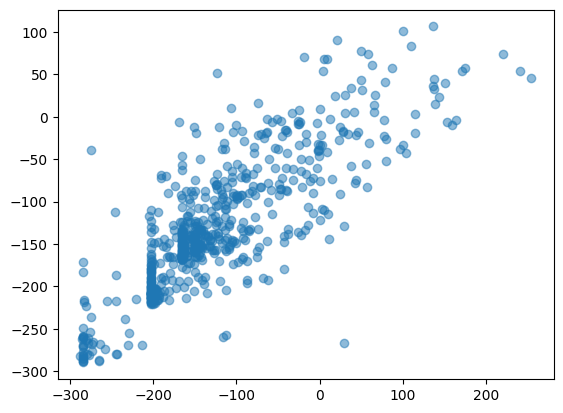

In [10]:
#quick regression
preds = rf_2022.predict(test_x_2022)
plt.scatter(test_y_2022, preds, alpha=.5)

0        9.00
1      144.18
2      171.26
3     -168.80
4        0.00
        ...  
639   -277.86
640   -280.54
641   -284.86
642   -284.86
643   -272.02
Name: nextSeasonPAR, Length: 644, dtype: float64

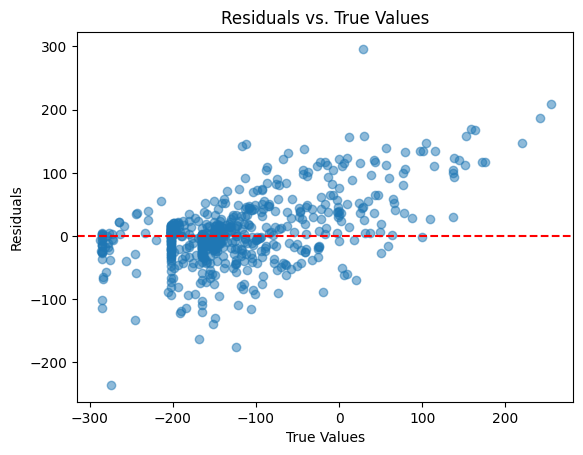

In [22]:
#residuals plot
residuals = test_y_2022.iloc[:, 0] - preds

# Plot residuals
plt.scatter(test_y_2022, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

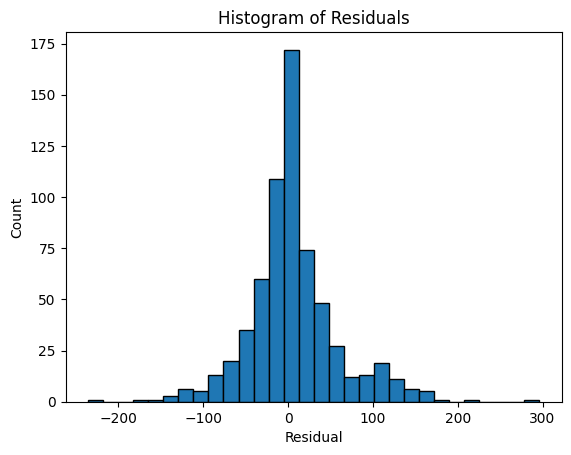

In [23]:
#residuals histogram
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

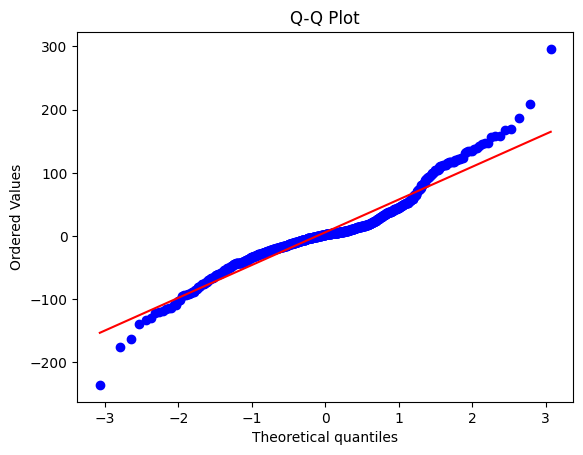

In [24]:
#qq plot
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In [25]:
#eval metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y_2022, preds)
mse = mean_squared_error(test_y_2022, preds)
r2 = r2_score(test_y_2022, rf_2022.predict(test_x_2022))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 36.12028068322981, MSE: 2891.335805279812, R^2: 0.6703781558399704


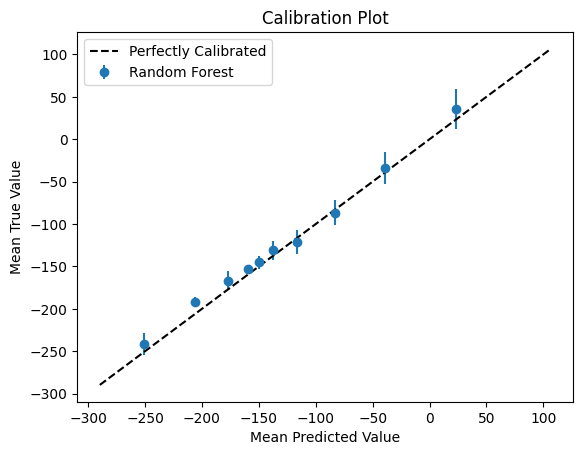

In [29]:
#calibration
df_calib = pd.DataFrame({'predictions': preds, 'true': test_y_2022.iloc[:, 0]})
df_calib['pred_decile'] = pd.qcut(preds, q=10, labels=False)
grouped = df_calib.groupby('pred_decile').mean()

# Compute standard error for each group
grouped_std = df_calib.groupby('pred_decile')['true'].std()
grouped_count = df_calib.groupby('pred_decile').size()
margin_of_error = 1.96 * (grouped_std / np.sqrt(grouped_count))

plt.errorbar(grouped['predictions'], grouped['true'], yerr=margin_of_error, fmt='o', label='Random Forest')
plt.plot([min(preds), max(preds)], [min(preds), max(preds)], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Mean True Value')
plt.title('Calibration Plot')
plt.legend()
plt.show()

In [49]:
import pandas as pd
from scipy.stats import spearmanr

# Assuming c2_whole_2022, preds, and test_y_2022 are already loaded

# Add predictions to the dataframe
c2_whole_2022['predictions'] = preds

# Rank the predictions and the actuals
c2_whole_2022['predicted_rank'] = c2_whole_2022['predictions'].rank(ascending=False)
c2_whole_2022['actual_rank'] = test_y_2022.iloc[:, 0].rank(ascending=False)

# Extract top-30 from your model's predictions and actual rankings
top_30_predicted = set(c2_whole_2022.nsmallest(30, 'predicted_rank')['Name'])
top_30_actuals = set(c2_whole_2022.nsmallest(30, 'actual_rank')['Name'])

# Calculate top-30 accuracy
accuracy_top_30 = len(top_30_predicted.intersection(top_30_actuals)) / 30.0

# Compute Spearman's rank correlation for your model
corr, _ = spearmanr(c2_whole_2022['predicted_rank'], c2_whole_2022['actual_rank'])

# Rank the ESPN predictions
c2_whole_2022['espn_rank'] = c2_whole_2022['rank']

# Extract top-30 from ESPN rankings
top_30_espn = set(c2_whole_2022.nsmallest(30, 'espn_rank')['Name'])

# Calculate top-30 accuracy for ESPN
accuracy_top_30_espn = len(top_30_espn.intersection(top_30_actuals)) / 30.0

# Compute Spearman's rank correlation for ESPN
corr_espn, _ = spearmanr(c2_whole_2022['espn_rank'], c2_whole_2022['actual_rank'])

print(f"Your Model's Top-30 Accuracy: {accuracy_top_30:.2f}")
print(f"ESPN's Top-30 Accuracy: {accuracy_top_30_espn:.2f}")
print(f"Your Model's Spearman's Rank Correlation: {corr:.2f}")
print(f"ESPN's Spearman's Rank Correlation: {corr_espn:.2f}")


Your Model's Top-30 Accuracy: 0.53
ESPN's Top-30 Accuracy: 0.47
Your Model's Spearman's Rank Correlation: 0.80
ESPN's Spearman's Rank Correlation: 0.68
